### 1. Import Required Libraries and Read in Data


#### 1.1 Import necessary libraries 

In [172]:
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem, DataStructs, PandasTools
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier


#### 1.2 Read in the BBB dataset from Adenot paper

In [173]:
bbbneg = pd.read_csv("Adenot_BBB-.csv", names=['Drug', 'SMILES'])
bbbneg['permeable'] = np.zeros(len(bbbneg))
bbbneg

,Drug,SMILES,permeable
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0
...,...,...,...
350,KETOCONAZOLE,CC(=O)N1CCN(CC1)c1ccc(cc1)OCC1CO[C@@](Cn2ccnc2...,0.0
351,SPIRAMYCIN,CO[C@H]1[C@H](O)CC(=O)O[C@H](C)CC=CC=C[C@H](OC...,0.0
352,TEICOPLANIN,COC(=O)C1NC(=O)[C@H]2NC(=O)[C@H](NC(=O)[C@@H]3...,0.0
353,TERFENADINE,CC(C)(C)c1ccc(cc1)C(O)CCCN1CCC(CC1)C(O)(c1cccc...,0.0


In [174]:
bbbpos = pd.read_csv("Adenot_BBB+.csv", names=['Drug', 'SMILES'])
bbbpos['permeable'] = np.ones(len(bbbpos))
bbbpos

,Drug,SMILES,permeable
0,ADENOSYL-METHIONINE,C[S+](CC[C@H](N)C([O-])=O)C[C@H]1O[C@H]([C@H](...,1.0
1,ACEGLUTAMIDE,CC(=O)N[C@@H](CCC(N)=O)C(O)=O,1.0
2,ATROMEPINE,CN1C2CCC1CC(C2)OC(=O)C(C)(CO)c1ccccc1,1.0
3,ATROPINE,CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C(CO)c1ccccc1,1.0
4,BENZATROPINE,CN1[C@H]2CC[C@@H]1CC(C2)OC(c1ccccc1)c1ccccc1,1.0
...,...,...,...
1332,AMITRIPTYLINE,CN(C)CCC=C1c2ccccc2CCc2ccccc12,1.0
1333,CHLORPROMAZINE,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)Cl,1.0
1334,DISULFIRAM,CCN(CC)C(=S)SSC(=S)N(CC)CC,1.0
1335,MORPHINE,CN1CC[C@@]23[C@H]4Oc5c(ccc(c52)C[C@@H]1[C@@H]3...,1.0


### 2. Data Preprocessing

In [175]:
bbb_df = pd.concat([bbbneg, bbbpos])
print(bbb_df.shape)
bbb_df.reset_index(inplace=True, drop=True)

(1692, 3)


In [176]:
bbb_df['SMILES'][5]

'COc1ccc(cc1)CCN1CCC(CC1)Nc1nc2ccccc2n1Cc1ccc(cc1)F'

In [177]:
clean_smiles = []

for i in range(len(bbb_df['SMILES'])):
  clean = max(str(bbb_df['SMILES'][i]).split("."), key = len) # split the smiles by ".", and keep the longest substring
  clean_smiles.append(clean)
  
bbb_df['SMILES'] = clean_smiles

In [178]:
updated_smiles = bbb_df["SMILES"]
updated_count = 0

for i in range(len(updated_smiles)):
  if "." in updated_smiles[i]:
    updated_count += 1
print("After cleaning there is {} molecule with salts in their smiles.".format(updated_count))

After cleaning there is 0 molecule with salts in their smiles.


In [179]:
#delete missing data
bbb_df.dropna(subset = ['Drug', 'SMILES', 'permeable'], inplace = True)
print(bbb_df.shape)

(1692, 3)


In [180]:
#multiple components
multiple_components = [smile for smile in bbb_df['SMILES'] if '.' in smile]
print('Number with Multiple Components: ', len(multiple_components))

Number with Multiple Components:  0


In [181]:
#remove duplicates
print('There are {} duplicates in BBB dataset.'.format(sum(bbb_df.duplicated('SMILES'))))
bbb_df.drop_duplicates(subset='SMILES', keep = 'first', inplace = True)
bbb_df.reset_index(drop = True, inplace = True)
print('After cleaning, there are {} duplicates left in BBB dataset.'.format(sum(bbb_df.duplicated('SMILES'))))

There are 20 duplicates in BBB dataset.
After cleaning, there are 0 duplicates left in BBB dataset.


In [182]:
bbb_df['permeable'] = bbb_df['permeable'].astype(int)

In [183]:
bbb_df.to_csv(r'adenot.csv', index=False)

#### 2.1 Molecule encoding

use the Morgan Fingerprints (radius = 2, nBits = 1024) as our molecular descriptors

In [184]:
PandasTools.AddMoleculeColumnToFrame(bbb_df,'SMILES','molecule')

# generate Morgan Fingerprints and save the results into an array (please also display your fingerprint array shape)
X = [AllChem.GetMorganFingerprintAsBitVect(m,2,1024,useChirality=False) for m in bbb_df['molecule']]


[21:02:44] SMILES Parse Error: syntax error while parsing: CO[C@]1(NC(=O)CSC[C@@H]([N+H3])C([O-])=O)[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc1nnnn1C
[21:02:44] SMILES Parse Error: Failed parsing SMILES 'CO[C@]1(NC(=O)CSC[C@@H]([N+H3])C([O-])=O)[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc1nnnn1C' for input: 'CO[C@]1(NC(=O)CSC[C@@H]([N+H3])C([O-])=O)[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc1nnnn1C'
[21:02:44] SMILES Parse Error: syntax error while parsing: nan
[21:02:44] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'


ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, boost::python::api::object invariants=[], boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

In [185]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
columns = calc.GetDescriptorNames()
descriptors = []
for mol in bbb_df['molecule']:
    ds = calc.CalcDescriptors(mol)
    descriptors.append(list(ds))

descriptors_df = pd.DataFrame(descriptors)
 
# specifying column names
descriptors_df.columns = columns 

bbb_df = pd.concat([bbb_df, descriptors_df], axis=1)

Traceback (most recent call last):
  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/Chem/EState/EState.py", line 76, in MaxEStateIndex
    return max(EStateIndices(mol, force))
  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/Chem/EState/EState.py", line 46, in EStateIndices
    nAtoms = mol.GetNumAtoms()
AttributeError: 'NoneType' object has no attribute 'GetNumAtoms'
Traceback (most recent call last):
  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/Chem/EState/EState.py", line 83, in MinEStateIndex
    return min(EStateIndices(mol, force))
  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/

  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/Chem/Fragments.py", line 46, in <lambda>
    fn = lambda mol, countUnique=True, pattern=patt: _CountMatches(mol, pattern, unique=countUnique)
  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/Chem/Fragments.py", line 24, in _CountMatches
    return len(mol.GetSubstructMatches(patt, uniquify=unique))
AttributeError: 'NoneType' object has no attribute 'GetSubstructMatches'
Traceback (most recent call last):
  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/rdkit/Chem/EState/EState.py", line 76, in MaxEStateIndex
    return max(EStateIndices(mol, force))
  File "/opt/anacond

In [190]:
bbb_df.dropna(inplace=True)
#bbb_df.replace([np.inf, -np.inf], np.nan, inplace=True)
bbb_df = bbb_df[np.isfinite(bbb_df).all(1)]

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

,Drug,SMILES,permeable,molecule,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0,,11.822073,-0.670239,11.822073,0.084862,0.571014,336.432,...,0,0,0,0,0,0,0,0,0,0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0,,15.183043,-1.883874,15.183043,0.076303,0.117861,1255.438,...,0,0,0,0,0,0,0,0,0,0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0,,12.289812,-0.830892,12.289812,0.038568,0.749582,360.450,...,0,0,0,0,0,0,0,0,0,0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0,,11.325545,-0.769074,11.325545,0.075424,0.304361,229.631,...,0,0,0,0,0,0,0,0,0,0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0,,13.588032,0.015348,13.588032,0.015348,0.167647,645.319,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,AMITRIPTYLINE,CN(C)CCC=C1c2ccccc2CCc2ccccc12,1,,2.419630,1.088296,2.419630,1.088296,0.813678,277.411,...,0,0,0,0,0,0,0,0,0,0
1668,CHLORPROMAZINE,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)Cl,1,,6.209384,0.797538,6.209384,0.797538,0.791805,318.873,...,0,0,0,0,0,0,0,0,0,0
1669,DISULFIRAM,CCN(CC)C(=S)SSC(=S)N(CC)CC,1,,5.341121,0.920839,5.341121,0.920839,0.573135,296.552,...,0,0,0,0,0,0,0,0,0,0
1670,MORPHINE,CN1CC[C@@]23[C@H]4Oc5c(ccc(c52)C[C@@H]1[C@@H]3...,1,,10.440693,-0.594392,10.440693,0.159722,0.703347,285.343,...,0,0,0,0,0,0,0,0,0,0

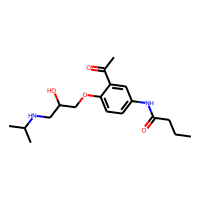
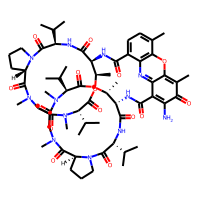
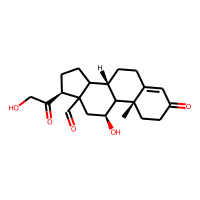
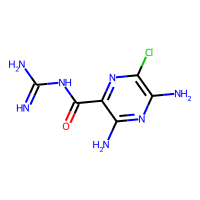
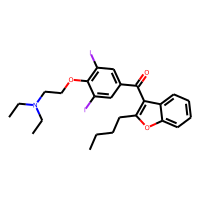
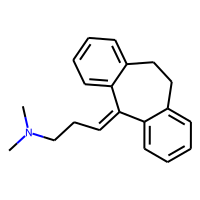
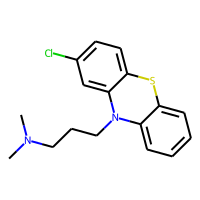
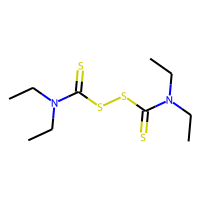
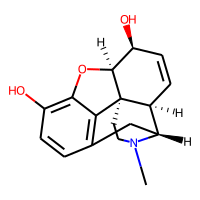
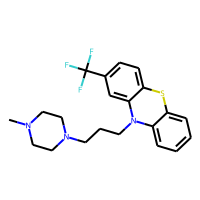

In [191]:
bbb_df

In [187]:
# Please write your code below:
X = bbb_df.iloc[:,4:].values
y = bbb_df.iloc[:,2].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 3. Construct Decision Tree ML Model

In [188]:
# Create a Decision Tree classifier object
dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, random_state=0)

# Train Decision Tree classifier
dt = dt.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = dt.predict(X_test)

# Calculate how often the classifier is correct
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

ValueError: Input X contains infinity or a value too large for dtype('float32').

In [ ]:
bbb_df